# UCCC2513 Project Work

# Traffic sign segmentation for autonomous vehicles

# Libraries

In [19]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install scikit-image

!pip install glob2
!pip install times

In [133]:
# import libraries 
import sys
assert sys.version_info >= (3,7)

import time
import glob
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import hsv_to_rgb
import matplotlib.image as mpimg

from skimage.io import imread
from skimage.color import rgb2gray, gray2rgb
from skimage.exposure import is_low_contrast

import os

if not cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

True

# Input

In [6]:
# import images
filename = "input 1"
sign_list = []
resize_dimension = (416, 416)

for i in glob.glob('input 1/*.png'):
    img_sign = cv.resize(cv.imread(i), resize_dimension)
    rgb_sign = cv.cvtColor(img_sign, cv.COLOR_BGR2RGB)
    sign_list.append(rgb_sign)

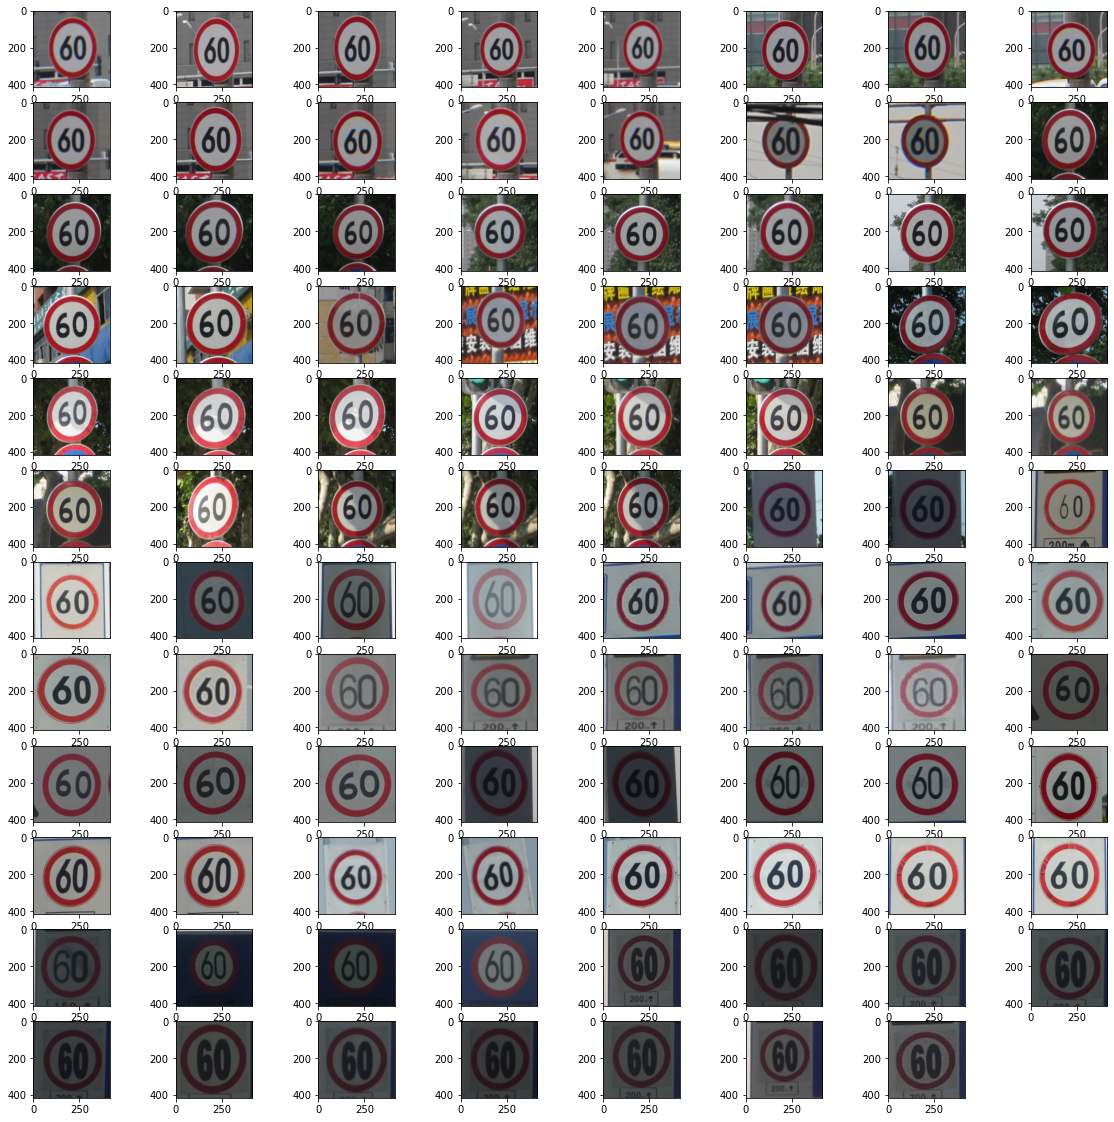

In [7]:
# display original images
# total 96 images
fig = plt.figure(figsize=(20, 20))
columns = 8
rows = 12

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(sign_list[i])
plt.show()

# Preprocessing

In [100]:
# image brightness normalisation
def preprocessing(img):
    thresh=0.73
    image = img
    gray = cv.cvtColor(image,cv.COLOR_RGB2GRAY)
    if is_low_contrast(gray, fraction_threshold=thresh):
        new_image = np.zeros(image.shape, image.dtype)
        alpha = 1.3 
        beta = 40    

        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                for c in range(image.shape[2]):
                    new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
    else:
        new_image=image
    
    return new_image

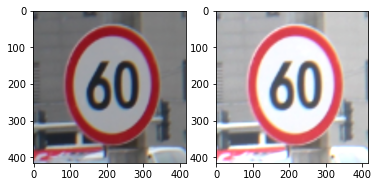

In [156]:
# test preprocessing
sign_list_test = sign_list[1]
img_list_test_processed =[]

image_test = preprocessing(sign_list_test)
img_list_test_processed.append(image_test)
    
plt.subplot(121)
plt.imshow(sign_list_test)
plt.subplot(122)
plt.imshow(image_test)
plt.show()

In [22]:
# function to visualise color of the image 
# to get the value of the color
def visualising_hsv(img):
    # to hsv color
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    # split hsv
    h, s, v = cv.split(img_hsv)
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection = "3d")
    
    # normalise
    pixel_colors = img.reshape((img.shape[0]*img.shape[1], 3))
    norm = colors.Normalize(vmin = -1., vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    # plot
    axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors = pixel_colors,
            marker = ".")
    axis.set_xlabel("Hue")
    axis.set_ylabel("Saturation")
    axis.set_zlabel("Value")
    plt.show()

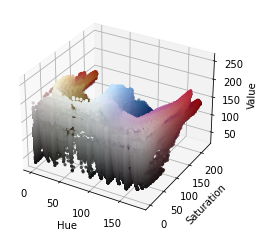

In [157]:
visualising_hsv(sign_list[1])

# Detection (color masking)

In [162]:
def detection_colorMasking(img):
    # to hsv color
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    # define red color
    red_min = (125, 50, 20)
    red_max = (179, 255, 250)
    
    # masking
    mask = cv.inRange(hsv, red_min, red_max)
    res = cv.bitwise_and(img, img, mask = mask)
    
    result = cv.GaussianBlur(res, (5, 5), 0)
    kernel = np.ones((1,1), np.uint8)  
    result = cv.dilate(result, kernel, iterations=1)
    
    gray_img = cv.cvtColor(result, cv.COLOR_RGB2GRAY)
    ret, threshold = cv.threshold(gray_img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    return result, threshold

# process segmentation
#results = [segment_porcelain(img) for img in sign_list]

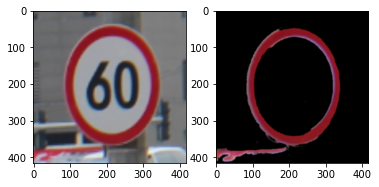

In [159]:
# detection using color masking
# testing on 1 images
result_colorMasking, threshold = detection_colorMasking(sign_list[1])
plt.subplot(121)
plt.imshow(sign_list[1])
plt.subplot(122)
plt.imshow(result_colorMasking)
plt.show()

In [26]:
def draw_boundingBox(ori_img, segmented_th):
    result = ori_img.copy()
    contours = cv.findContours(segmented_th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contours = sorted(contours, key=lambda c: cv.contourArea(c), reverse=True)
    roi_coordinate = []
    for cntr in contours:
        x,y,w,h = cv.boundingRect(cntr)
        #x,y,w,h = x-10,y-20,w+25,h+20
        cv.rectangle(result, (x, y), (x+w, y+h), (255,255,0), 1)
        roi_coordinate.append([x,y,w,h])
        print("x,y,w,h:",x,y,w,h)
    return result, roi_coordinate

x,y,w,h: 82 49 256 326
x,y,w,h: 0 372 196 41
x,y,w,h: 153 355 1 1


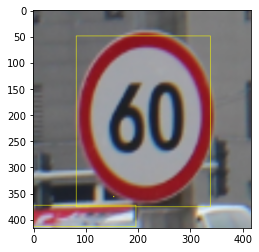

In [27]:
gray_img = cv.cvtColor(result_colorMasking, cv.COLOR_RGB2GRAY)
ret, th = cv.threshold(gray_img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

result, roi_coordinate = draw_boundingBox(sign_list[1], th)
plt.imshow(result)
plt.show()

# Detection (CNN)

In [28]:
# load the model config and weights
modelConfig_path = './cnn_model/yolov4-rds.cfg'
modelWeights_path = './cnn_model/yolov4-rds_best_2000.weights'

neural_net = cv.dnn.readNetFromDarknet(modelConfig_path, modelWeights_path)

neural_net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
neural_net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)

network = neural_net
height, width = 416,416

confidenceThreshold = 0.5
nmsThreshold = 0.2

In [29]:
def convert_to_blob(input_img, network, height, width):
    
    blob = cv.dnn.blobFromImage(input_img, 1/255, (height,width), [0,0,0], 1, crop=False)
    network.setInput(blob)
   
    yoloLayers = network.getLayerNames()
    outputLayers = [(yoloLayers[i-1]) for i in network.getUnconnectedOutLayers()]
    
    outputs = network.forward(outputLayers)
    
    return outputs

In [30]:
# object detection function
def object_detection(outputs, input_img, confidenceThreshold):
    
    height, width, channel = input_img.shape
    
    bounding_boxes = []
    class_objects = []
    confidence_probs = []
    
    for result in outputs:        
        for values in result:
            
            scores = values[5:] 
            indices_object = np.argmax(scores) 
            confidence_probability = scores[indices_object] 
            
            if confidence_probability > confidenceThreshold:   
                
                box_detected = values[0:4] * np.array([width, height, width, height])                                 
                
                x, y, w, h = box_detected
                x = int(x - (w/2))
                y = int(y - (h/2))
                

                bounding_boxes.append([x,y,w,h])                

                class_objects.append(indices_object)                

                confidence_probs.append(float(confidence_probability))    
    
    return bounding_boxes, class_objects, confidence_probs


In [31]:
# non max-suppression function
def nms_bbox(bounding_boxes, confidence_probs, confidenceThreshold, nmsThreshold):  

    indices_bbox = cv.dnn.NMSBoxes(bounding_boxes, confidence_probs, confidenceThreshold, nmsThreshold)   
    print('Number of traffic sign detected : ', len(indices_bbox))
    
    return indices_bbox

In [32]:
def box_drawing_forCNN(input_img, indices, bounding_boxes, class_objects, confidence_probs):
    roi_coordinate = []
    for i in indices:
        final_box = bounding_boxes[i]
        x, y, w, h = final_box[0], final_box[1], final_box[2], final_box[3]
        x, y, w, h = int(x), int(y), int(w), int(h)
        
        roi_coordinate.append([x,y,w,h])
        print('Bounding box coordination (x,y,w,h):',x,y,w,h,'\n')

        cv.rectangle(input_img, (x,y), (x+w,y+h), color=(255,255,0), thickness=1)
    return roi_coordinate

In [33]:
# compile n run cnn method
def detection_cnn(image):
    img = image
    
    outputs = convert_to_blob(img, network, height, width)    

    bounding_boxes, class_objects, confidence_probs = object_detection(outputs, img, confidenceThreshold)   
    
    indices = nms_bbox(bounding_boxes, confidence_probs, confidenceThreshold, nmsThreshold)
    roi_coordinate = box_drawing_forCNN(img, indices, bounding_boxes, class_objects, confidence_probs)

    return img, roi_coordinate

# Segmentation (GrabCut)

In [108]:
def segmentation_grabCut(img, roi_coordinate):
    if roi_coordinate:
        mask = np.zeros(img.shape[:2],np.uint8)
        rect = roi_coordinate[0]
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
    
        cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
        mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
        img_segmented = img*mask2[:,:,np.newaxis]
    else:
        img_segmented = img
        
    return img_segmented

# Testing for 1 image

x,y,w,h: 200 5 32 46
x,y,w,h: 197 53 34 28
x,y,w,h: 70 40 17 7
x,y,w,h: 104 55 4 5
x,y,w,h: 112 37 5 2
x,y,w,h: 112 112 4 2
x,y,w,h: 64 60 3 3
x,y,w,h: 65 45 3 3
x,y,w,h: 96 39 3 3
x,y,w,h: 158 105 2 2
x,y,w,h: 238 51 2 2
x,y,w,h: 110 27 2 2
x,y,w,h: 158 100 1 1
x,y,w,h: 104 40 2 1
x,y,w,h: 65 38 2 1
x,y,w,h: 115 31 1 1


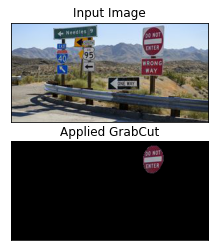

In [35]:
#testing for segmentation (color masking)
imgtest = plt.imread('interstate-40-in-california-near-needles-usa-royalty-free-image-958412190-1567697186.jpg')

testresult_colorMasking, testresult_threshold = detection_colorMasking(imgtest)
testresult_boundingBox, test_roi = draw_boundingBox(imgtest, testresult_threshold)
imgtest_cut = segmentation_grabCut(imgtest, test_roi)

plt.subplot(211),plt.imshow(imgtest)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(imgtest_cut)
plt.title('Applied GrabCut'), plt.xticks([]), plt.yticks([])
plt.show()

# Run the program

for group of photos

In [163]:
# color masking method
# pre-processing -> detection -> segmentation -> post-processing

imgSegmented_list1 = []
imgBoundingBox_list1 = []
sign_list1 = sign_list.copy()

for iteration, img in enumerate(sign_list1):
    #initiation 
    image = img
    print("pre-processing...")
    image = preprocessing(image)
    print("pre-process done")
    
    #record start time
    start_time = time.time()
    
    #detection
    result_colorMasking, threshold_colorMasking = detection_colorMasking(image)
    result_boundingBox, roi_coordinate = draw_boundingBox(image, threshold_colorMasking)
    imgBoundingBox_list1.append(result_boundingBox)
    
    #segmentation
    img_segmented = segmentation_grabCut(image, roi_coordinate)
    
    #record end time
    end_time = time.time()
    
    #record operation duration
    #The operation should run in real time and take less than 2 seconds on any of the lab machines for each image
    print('Picture {0} took {1:.5f} seconds for segmentation\n'.format(iteration, end_time - start_time))
    
    #save end result
    imgSegmented_list1.append(img_segmented)


pre-processing...
pre-process done
x,y,w,h: 76 50 266 311
x,y,w,h: 41 366 85 50
Picture 0 took 0.38109 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 84 49 254 323
x,y,w,h: 100 373 91 20
x,y,w,h: 0 376 32 11
x,y,w,h: 20 407 3 2
Picture 1 took 0.46640 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 95 48 247 344
x,y,w,h: 352 414 4 2
Picture 2 took 0.35408 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 86 36 253 347
x,y,w,h: 5 401 187 15
x,y,w,h: 123 410 4 2
x,y,w,h: 110 395 4 2
Picture 3 took 0.38309 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 103 67 227 290
x,y,w,h: 165 377 37 13
x,y,w,h: 334 369 51 6
x,y,w,h: 302 375 19 13
x,y,w,h: 303 392 8 18
x,y,w,h: 123 382 7 17
x,y,w,h: 194 404 8 9
x,y,w,h: 91 382 8 17
x,y,w,h: 71 409 6 7
x,y,w,h: 109 383 7 3
x,y,w,h: 156 406 3 10
x,y,w,h: 203 408 2 3
Picture 4 took 0.34708 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 107 56 214 

Picture 30 took 0.58213 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 66 52 298 310
x,y,w,h: 129 364 222 52
Picture 31 took 0.52912 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 45 39 338 330
x,y,w,h: 132 372 228 44
Picture 32 took 0.62514 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 78 45 263 302
x,y,w,h: 123 358 206 58
x,y,w,h: 209 352 5 3
x,y,w,h: 293 367 3 3
x,y,w,h: 309 377 1 1
Picture 33 took 0.50211 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 63 54 304 327
x,y,w,h: 160 393 146 23
x,y,w,h: 219 386 5 2
x,y,w,h: 310 404 3 3
x,y,w,h: 244 385 2 2
Picture 34 took 0.57313 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 65 38 291 337
x,y,w,h: 153 392 149 24
x,y,w,h: 174 380 81 14
x,y,w,h: 275 390 28 13
x,y,w,h: 305 406 16 10
x,y,w,h: 265 386 8 5
x,y,w,h: 154 401 4 2
Picture 35 took 0.64915 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 68 59 287

pre-process done
x,y,w,h: 41 35 336 341
Picture 66 took 0.41809 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 40 51 357 338
Picture 67 took 0.41709 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 51 27 309 353
x,y,w,h: 244 378 3 2
Picture 68 took 0.62314 seconds for segmentation

pre-processing...
pre-process done
x,y,w,h: 54 41 311 343
x,y,w,h: 249 377 20 8
x,y,w,h: 206 386 17 3
x,y,w,h: 327 323 10 14
x,y,w,h: 310 344 10 9
x,y,w,h: 350 292 5 10
x,y,w,h: 238 384 8 3
x,y,w,h: 287 364 8 5
x,y,w,h: 297 356 10 6
x,y,w,h: 110 339 7 6
x,y,w,h: 90 315 6 8
x,y,w,h: 48 201 2 9
x,y,w,h: 55 146 4 6
x,y,w,h: 194 384 5 2
x,y,w,h: 58 257 4 5
x,y,w,h: 342 311 4 4
x,y,w,h: 75 293 3 4
x,y,w,h: 231 386 4 2
x,y,w,h: 347 304 2 4
x,y,w,h: 55 248 2 2
x,y,w,h: 351 146 2 2
x,y,w,h: 116 63 2 2
x,y,w,h: 135 359 1 1
x,y,w,h: 106 335 1 2
x,y,w,h: 359 279 1 2
x,y,w,h: 363 264 1 1
x,y,w,h: 68 120 2 1
x,y,w,h: 103 74 2 1
Picture 69 took 0.66915 seconds for segmentation



Picture 95 took 0.71216 seconds for segmentation



In [111]:
# cnn method
# pre-processing -> detection -> segmentation -> post-processing

imgSegmented_list2 = []
imgBoundingBox_list2 = []
sign_list2 = sign_list.copy()

for iteration, img in enumerate(sign_list2):
    #initiation 
    image = img
    print("pre-processing...")
    image = preprocessing(image)
    print("pre-process done")
    
    #record start time
    start_time = time.time()
    
    #detection
    result_boundingBox, roi_coordinate = detection_cnn(image)
    imgBoundingBox_list2.append(result_boundingBox)
    
    #segmentation
    img_segmented = segmentation_grabCut(image, roi_coordinate)
    
    #record end time
    end_time = time.time()
    
    #record operation duration
    #The operation should run in real time and take less than 2 seconds on any of the lab machines for each image
    print('Picture {0} took {1:.5f} seconds for segmentation\n'.format(iteration, end_time - start_time))
    
    #save result
    imgSegmented_list2.append(img_segmented)


pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 78 30 260 348 

Picture 0 took 1.30390 seconds

pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 89 1 246 407 

Picture 1 took 1.69939 seconds

pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 106 29 222 372 

Picture 2 took 1.17527 seconds

pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 102 16 221 382 

Picture 3 took 1.20927 seconds

pre-processing...
pre-process done
Number of traffic sign detected :  2
Bounding box coordination (x,y,w,h): 114 43 210 331 

Bounding box coordination (x,y,w,h): 305 366 84 45 

Picture 4 took 1.18127 seconds

pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 120 14 192 370 

Picture 5 took 1.43434 seconds

pr

Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 47 43 320 329 

Picture 51 took 1.02323 seconds

pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 78 49 262 315 

Picture 52 took 1.44133 seconds

pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 78 53 265 316 

Picture 53 took 1.44371 seconds

pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 87 68 258 290 

Picture 54 took 1.45133 seconds

pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 68 52 289 315 

Picture 55 took 1.48455 seconds

pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 71 53 293 321 

Picture 56 took 1.63637 seconds

pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box co

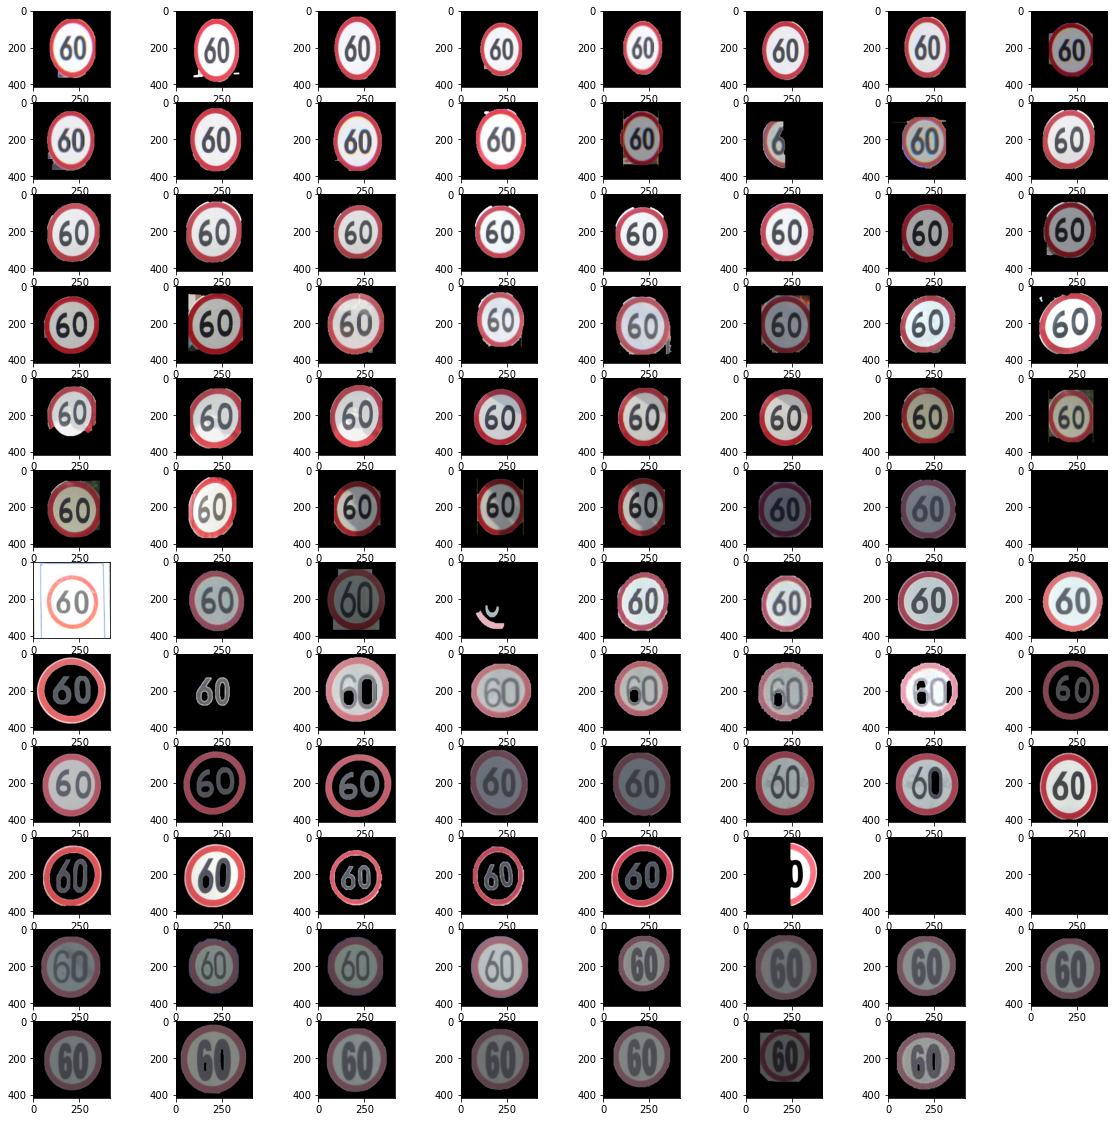

In [165]:
# color masking detection method
fig = plt.figure(figsize=(20, 20))
columns = 8
rows = 12

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imgSegmented_list1[i])
plt.show()

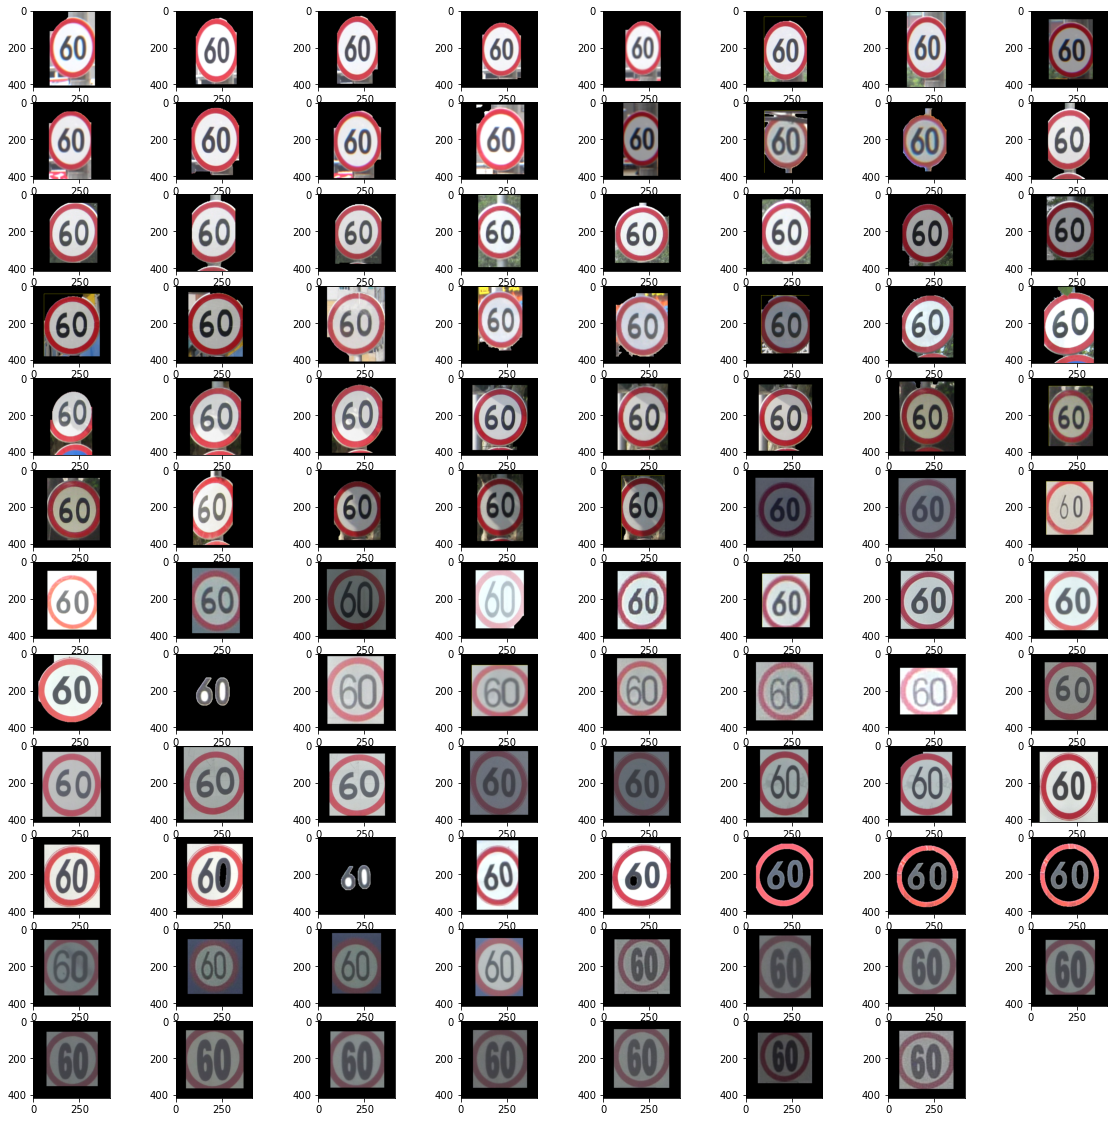

In [112]:
# cnn detection method
fig = plt.figure(figsize=(20, 20))
columns = 8
rows = 12

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imgSegmented_list2[i])
plt.show()

# Program for single photo

pre-processing...
pre-process done
Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 470 -2 319 300 

Picture 0 took 1.13926 seconds



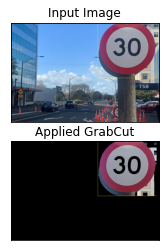

In [113]:
# cnn method
# pre-processing -> detection -> segmentation -> post-processing

imgSegmented_list3 = []
imgBoundingBox_list3 = []
single_img = plt.imread("speed-limit2.jpg")
sign_list3 = []
sign_list3.append(single_img)

for iteration, img in enumerate(sign_list3):
    #initiation 
    image = img
    print("pre-processing...")
    image = preprocessing(image)
    print("pre-process done")
    
    #record start time
    start_time = time.time()
    
    #detection
    result_boundingBox, roi_coordinate = detection_cnn(image)
    imgBoundingBox_list3.append(result_boundingBox)
    
    #segmentation
    img_segmented = segmentation_grabCut(image, roi_coordinate)
    
    #record end time
    end_time = time.time()
    
    #record operation duration
    #The operation should run in real time and take less than 2 seconds on any of the lab machines for each image
    print('Picture {0} took {1:.5f} seconds for segmentation\n'.format(iteration, end_time - start_time))
    
    #save result
    imgSegmented_list3.append(img_segmented)

plt.subplot(211),plt.imshow(single_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(imgSegmented_list3[0])
plt.title('Applied GrabCut'), plt.xticks([]), plt.yticks([])
plt.show()

# Post - processing

In [166]:
def postprocessing(ori_list, result_list, dir_name):
    if os.path.isdir(dir_name) is None:
        os.mkdir(dir_name)
    print("saving...")
    for i, img in enumerate(ori_list):
        image_combined = np.hstack((ori_list[i], result_list[i]))
        mpimg.imsave(f'{dir_name}/result_{i}.png', image_combined)
    print(f"export to /{dir_name}/ done")

In [167]:
postprocessing(sign_list, imgSegmented_list1, 'segmented images part1')

saving...
export to /segmented images part1/ done


In [168]:
postprocessing(sign_list, imgSegmented_list2, 'segmented images part2')

saving...
export to /segmented images part2/ done


# Evaluation and Testing

Number of traffic sign detected :  1
Bounding box coordination (x,y,w,h): 79 74 222 192 

Picture 0 took 0.72818 seconds



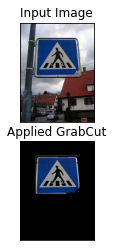

In [118]:
# cnn method
# pre-processing -> detection -> segmentation -> post-processing

imgSegmented_list3 = []
imgBoundingBox_list3 = []
single_img = plt.imread("crosswalk5.jpg")
sign_list3 = []
sign_list3.append(single_img)

for iteration, img in enumerate(sign_list3):
    #initiation 
    image = img
    #print("pre-processing...")
    #image = preprocessing(image)
    #print("pre-process done")
    
    #record start time
    start_time = time.time()
    
    #detection
    result_boundingBox, roi_coordinate = detection_cnn(image)
    imgBoundingBox_list3.append(result_boundingBox)
    
    #segmentation
    img_segmented = segmentation_grabCut(image, roi_coordinate)
    
    #record end time
    end_time = time.time()
    
    #record operation duration
    #The operation should run in real time and take less than 2 seconds on any of the lab machines for each image
    print('Picture {0} took {1:.5f} seconds for segmentation\n'.format(iteration, end_time - start_time))
    
    #save result
    imgSegmented_list3.append(img_segmented)

plt.subplot(211),plt.imshow(single_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(imgSegmented_list3[0])
plt.title('Applied GrabCut'), plt.xticks([]), plt.yticks([])
plt.show()

x,y,w,h: 199 236 171 140
x,y,w,h: 55 353 131 61
x,y,w,h: 306 479 31 21
x,y,w,h: 0 361 17 27
x,y,w,h: 300 342 36 26
x,y,w,h: 208 401 17 20
x,y,w,h: 278 349 25 21
x,y,w,h: 110 430 19 12
x,y,w,h: 65 150 6 39
x,y,w,h: 228 264 25 6
x,y,w,h: 72 41 7 37
x,y,w,h: 205 363 13 12
x,y,w,h: 74 0 8 27
x,y,w,h: 134 468 16 12
x,y,w,h: 144 466 17 9
x,y,w,h: 172 365 11 13
x,y,w,h: 275 264 17 6
x,y,w,h: 143 481 21 5
x,y,w,h: 262 276 17 11
x,y,w,h: 352 273 15 13
x,y,w,h: 162 467 8 13
x,y,w,h: 366 234 9 20
x,y,w,h: 249 363 10 10
x,y,w,h: 361 346 8 15
x,y,w,h: 150 432 18 7
x,y,w,h: 55 339 7 22
x,y,w,h: 56 435 9 8
x,y,w,h: 43 85 18 10
x,y,w,h: 195 367 8 11
x,y,w,h: 151 79 18 3
x,y,w,h: 54 320 5 14
x,y,w,h: 64 135 8 14
x,y,w,h: 296 248 5 13
x,y,w,h: 362 243 8 9
x,y,w,h: 84 82 8 20
x,y,w,h: 367 294 8 13
x,y,w,h: 362 290 9 10
x,y,w,h: 111 453 13 5
x,y,w,h: 344 357 12 8
x,y,w,h: 253 264 12 6
x,y,w,h: 62 44 9 11
x,y,w,h: 55 304 5 11
x,y,w,h: 62 205 4 17
x,y,w,h: 80 142 5 9
x,y,w,h: 309 438 14 3
x,y,w,h: 90 426 11

Picture 0 took 0.39909 seconds



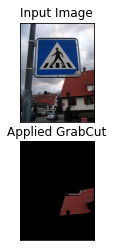

In [123]:
# color masking method
# pre-processing -> detection -> segmentation -> post-processing

imgSegmented_list3 = []
imgBoundingBox_list3 = []
single_img = plt.imread("crosswalk5.jpg")
sign_list3 = []
sign_list3.append(single_img)

for iteration, img in enumerate(sign_list3):
    #initiation 
    image = img
    
    #record start time
    start_time = time.time()
    
    #detection
    result_colorMasking, threshold_colorMasking = detection_colorMasking(image)
    result_boundingBox, roi_coordinate = draw_boundingBox(image, threshold_colorMasking)
    imgBoundingBox_list3.append(result_boundingBox)
    
    #segmentation
    img_segmented = segmentation_grabCut(image, roi_coordinate)
    
    #record end time
    end_time = time.time()
    
    #record operation duration
    #The operation should run in real time and take less than 2 seconds on any of the lab machines for each image
    print('Picture {0} took {1:.5f} seconds for segmentation\n'.format(iteration, end_time - start_time))
    
    #save result
    imgSegmented_list3.append(img_segmented)

plt.subplot(211),plt.imshow(single_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(imgSegmented_list3[0])
plt.title('Applied GrabCut'), plt.xticks([]), plt.yticks([])
plt.show()